## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
!pip install -r requirements.txt -U


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary packages
import re

import numpy as np
import control as ct

from typing import Callable, Tuple

import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
from modules.calc_resp import precompute_consts, calc_resp

def calc(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps,
    num_freqs=1_000,
    num_duty_cycles=100,
    num_harmonics=100.
) -> Tuple[np.ndarray]:
    consts = list(precompute_consts(num_freqs, num_duty_cycles, num_harmonics, (start, end)))
    
    mags, phs, osc_fs, dcins, dcgains = calc_resp(np.array(H.num[0]).T[::-1,:], np.array(H.den[0]).T[::-1,:], np.array([delay]), *consts)
    
    consts[0] = np.imag(consts[0]) / (2 * np.pi)
    osc_fs /= 2 * np.pi
    phs -= np.pi

    return (mags[0], phs[0], osc_fs[0], dcins[0], dcgains[0]), consts[:3]

In [4]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    (mags, phs, osc_fs, dcins, dcgains), (omega, hs, ns) = calc(H, start, end, delay)
          
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((2 * hs - 1, - 2 * hs[-1::-1] + 1)),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitudes
    mag_scaled = 20 * np.log10(dcgains[-1] * mags[-1])
    ax_mag.plot(omega, mag_scaled, 'r-')
    
    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

In [5]:
def lpf(L: float, C: float, R_load: float) -> ct.TransferFunction:
    """ Function representing a common 2nd order output filter for Class-D amplifiers.
    Returns a transfer function per the corresponding values
    """
    return ct.tf([R_load], [R_load * L * C, L, R_load])

def fbn_example(R_in, C_in, R_lead, C_lead, R_fb, R_sep) -> ct.TransferFunction:
    s = ct.tf('s')

    b = R_lead + 1 / (C_lead * s)

    a = b + R_sep

    H_n = R_in * (a + R_fb) / (R_fb * a + R_in * a + R_fb *  R_in * a * C_in * s + R_fb * R_in)

    H = (R_sep + H_n * b) / (R_sep + b)

    return H

## Workspace

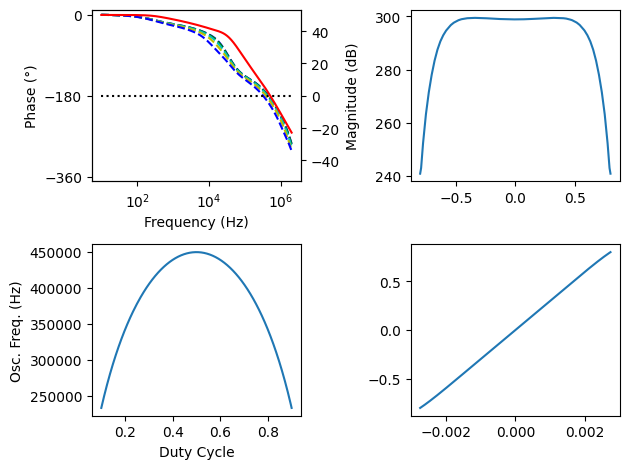

In [6]:
plot(
    lpf(30e-6, 680e-9, 4) *
    fbn_example(1.8e3, 2.2e-9, 1e3, 330e-12, 8.2e3, 680),
    10, 2e6, delay=160e-9
)

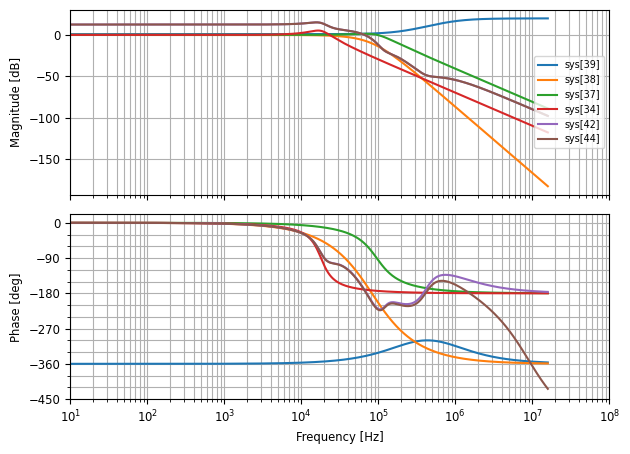

In [7]:
out = lpf(20e-6, 3.9e-6, 4)


iff = 50e3*2*np.pi

i_stages = list()
#for fsf, q in [(1.4192, 0.5219), (1.5912, 0.8055)]:
for fsf, q in [(1.6060, 0.5103), (1.6913, 0.6112), (1.9071, 1.0234)]:
    sf = iff * fsf
    i_stages.append(ct.tf([sf**2], [1, sf/q, sf**2]))

i_i = i_stages[0] * i_stages[1]
i_o = i_stages[2]

compf = 5*iff
compr = [3, 3]
comp = ct.zpk([-compf-1j, -compf+1j], [-r * compf for r in compr], 10)

fbn = (i_i + out) * (i_o + comp)
#fbn = i_i + out * (i_o + comp)

delay = 60e-9

plt.clf()

plot_kwargs = {'Hz': True, 'dB': True, 'omega_limits': (10, 100e6)}
for tf in (comp, i_i, i_o, out, fbn, fbn * ct.tf(*ct.pade(delay, n=2))):
    ct.bode_plot(tf, **plot_kwargs)

plt.show()

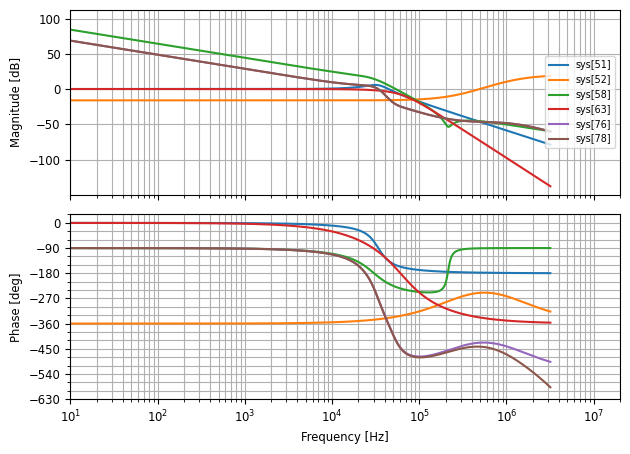

In [8]:
out = lpf(10e-6, 2.2e-6, 4)

ifilt = 4e4*2*np.pi

compfz = 7*ifilt
comp = ct.zpk([-compfz] * 3, [-4*compfz-1j, -4*compfz+1j, -4*compfz], 10)


intf = 3e4*2*np.pi
intt = (ct.tf([intf**2], [1, intf/1, intf**2]) + 2e-2) * (1e6 / ct.tf('s'))

ff = 1
for fsf, q in [(1.4192, 0.5219), (1.5912, 0.8055)]:
    f = fsf * ifilt
    ff *= ct.tf([f**2], [1, f/q, f**2])

fbks = [1e-5, 1e-2]
ffk = 0.5
fbn = out * ((fbks[0] * ff + fbks[1] + comp) * intt + ff * fbks[0] * ffk + comp)


delay = 80e-9

plt.clf()
for tf in (out, comp, intt, ff, fbn, fbn * ct.tf(*ct.pade(delay, 2))):
    ct.bode_plot(tf, Hz=True, dB=True, omega_limits=(10, 20e6))

plt.show()

In [9]:
def generate(x):
    # Define tf
    cfz, cfp1, cfp2, intf, intq, intk, intzk, fff, ffq, fbk1, fbk2, ffk, delay = x
    
    comp = ct.zpk([-cfz-1j, -cfz+1j], [-cfp1-1j, -cfp1+1j, -cfp2], 1e9)
    
    intt = intk * (ct.tf([intf**2], [1, intf/intq, intf**2]) + intzk) / ct.tf('s')
    
    ff = ct.tf([fff**2], [1, fff/ffq, fff**2])
    
    fbn = lpf(15e-6, 4.7e-6, 4) * ((fbk1 * ff + fbk2 + comp) * intt + ff * fbk1 * ffk + comp)

    return fbn, delay

In [10]:
def fitness_fn(x, t_osc, p_band, min_ph):

    H, delay = generate(x)

    # Return early if no zero-crossing around t_osc
    omega_lr = np.linspace(0.8*t_osc, 1.2*t_osc, num=100)
    g = np.unwrap(np.angle(H(2j * np.pi * omega_lr) * np.exp(-2j * np.pi * omega_lr * delay))) > -np.pi
    
    if not np.any(g[:-1] & ~g[1:]):
        return np.inf

    # Brunt of calculation
    (mags, phs, osc_fs, dcins, dcgains, ph_margins), (omega, hs, ns) = calc(H, 100, 1e6, delay, num_duty_cycles=10, num_freqs=300, num_harmonics=15)

    osc = osc_fs[-1]

    mag = np.min((mags[-1] * dcgains[-1])[omega <= 20e3 * 2 * np.pi])

    p_band_ks = dcgains[hs > 0.5 - p_band * 0.5]
    
    ripple = (max(p_band_ks) - min(p_band_ks)) / max(p_band_ks)

    ph_m_ratio = np.count_nonzero(np.degrees(ph_margins) > min_ph) / hs.size

    return (1e-3 * abs(osc - t_osc)) + (1e3 / mag) + (1e1 * ripple) + (1e-1 / max(ph_m_ratio, 1e-3))

In [11]:
from modules.sapwin import Sapwin

problem = Sapwin(filename='../sym_analysis/SapWin/class_d_ucd.out', n_fs=5_000, n_ns=500)

['4.*R2', '4.*C3*R3*R4+4.*C3*R2*R5+4.*C3*R2*R4+4.*C3*R2*R3', '4.*C3*C2*R2*R3*R4']
['4.*R4+4.*R2', '4.*C2*R2*R4+4.*C3*R4*R5+4.*C3*R3*R4+4.*C3*R2*R5+4.*C3*R2*R4+4.*C3*R2*R3+4.*L1+L1*R4+L1*R2', '4.*C1*L1*R4+4.*C1*L1*R2+4.*C3*C2*R2*R4*R5+4.*C3*C2*R2*R3*R4+4.*C2*L1*R2+C2*L1*R2*R4+4.*C3*L1*R5+4.*C3*L1*R4+C3*L1*R4*R5+4.*C3*L1*R3+C3*L1*R3*R4+C3*L1*R2*R5+C3*L1*R2*R4+C3*L1*R2*R3', '4.*C2*C1*L1*R2*R4+4.*C3*C1*L1*R4*R5+4.*C3*C1*L1*R3*R4+4.*C3*C1*L1*R2*R5+4.*C3*C1*L1*R2*R4+4.*C3*C1*L1*R2*R3+4.*C3*C2*L1*R2*R5+4.*C3*C2*L1*R2*R4+C3*C2*L1*R2*R4*R5+4.*C3*C2*L1*R2*R3+C3*C2*L1*R2*R3*R4', '4.*C3*C2*C1*L1*R2*R4*R5+4.*C3*C2*C1*L1*R2*R3*R4']


In [12]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.lhs import LHS

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=20,
    sampling=LHS(),
    crossover=SBX(prob=0.8, eta=20),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [13]:
from pymoo.optimize import minimize

res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=2,
    save_history=True,
    verbose=True
)

(100, 10)
[         inf          inf          inf          inf 215.55955467
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf


/Users/aaron/projects/class-d-amp/loop_analysis/python/.venv/lib/python3.11/site-packages/pymoo/operators/survival/rank_and_crowding/metrics.py:97: RuntimeWarning: invalid value encountered in subtract
  dist = np.row_stack([F, np.full(n_obj, np.inf)]) - np.row_stack([np.full(n_obj, -np.inf), F])
/Users/aaron/projects/class-d-amp/loop_analysis/python/.venv/lib/python3.11/site-packages/pymoo/operators/survival/rank_and_crowding/metrics.py:100: RuntimeWarning: invalid value encountered in subtract
  norm = np.max(F, axis=0) - np.min(F, axis=0)


(20, 10)
[7.35065885e+04            inf            inf 1.27322035e+05
 1.03872165e+05            inf 2.85265809e+04 7.41292964e+04
 2.84911392e+05 3.51166032e+02 5.68893924e+04 3.49465330e+05
            inf 9.43400499e+01 1.42401757e+02            inf
 1.46704773e+01 2.86374620e+01            inf            inf]
     2 |      120 |      2 |  1.0000000000 |         ideal


/Users/aaron/projects/class-d-amp/loop_analysis/python/.venv/lib/python3.11/site-packages/pymoo/operators/survival/rank_and_crowding/metrics.py:105: RuntimeWarning: invalid value encountered in divide
  dist_to_last, dist_to_next = dist_to_last[:-1] / norm, dist_to_next[1:] / norm


(20, 10)
[           inf            inf            inf 5.45835654e+04
 3.71898782e+05            inf 3.25733278e+04 1.23797532e+05
 3.41268789e+04 1.16964817e+02            inf 2.03493723e+05
 1.92350954e+02            inf 1.08643681e+02            inf
            inf 1.83575357e+02            inf            inf]
     3 |      140 |      2 |  0.0603563750 |         ideal


/Users/aaron/projects/class-d-amp/loop_analysis/python/modules/problem.py:56: RuntimeWarning: overflow encountered in power
  obj_lst.append(np.nan_to_num(1.01 ** -np.min((mag[:,-1] * dcgains[:,-1,None])[:,np.imag(fs) < 2 * np.pi * 20e3], axis=-1)))


(20, 10)
[2.75932085e+05 8.17505143e+04            inf 1.27515675e+05
 3.37231598e+04            inf 2.70541120e+04 1.58018374e+05
 3.09051247e+04            inf            inf 1.91528061e+05
 3.56723176e+01            inf            inf            inf
            inf 2.00459962e+02            inf            inf]
     4 |      160 |      2 |  0.000000E+00 |             f
(20, 10)
[8.25663430e+04 9.12965987e+04 1.31333615e+05 3.81414672e+04
 5.04672914e+04            inf 9.71816625e+04 1.20541377e+05
 4.08170653e+04 4.84135323e+01            inf 8.54263855e+04
 2.54985942e+01            inf 3.46697106e+01            inf
            inf            inf            inf            inf]
     5 |      180 |      2 |  0.000000E+00 |             f
(20, 10)
[2.67527222e+05 7.55293491e+04            inf 6.63624750e+04
 3.82931493e+04            inf 1.37432965e+05 1.37965992e+05
 1.37966051e+05            inf            inf 6.35366879e+05
            inf            inf 1.76272154e+01            inf

In [14]:
X = res.X
F = res.F

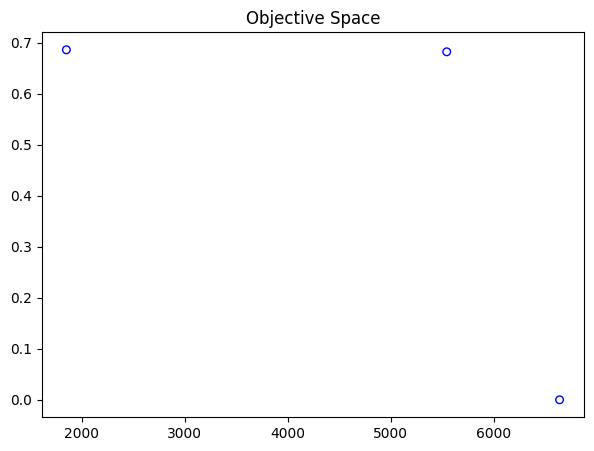

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [16]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [1849.5359143527457, 6637.821155441634]
Scale f2: [0.0, 0.6859348016762552]


In [17]:
print(F[:,0])

[6637.82115544 5542.2500407  1849.53591435]


(1, 10)
[1011084.56659066]


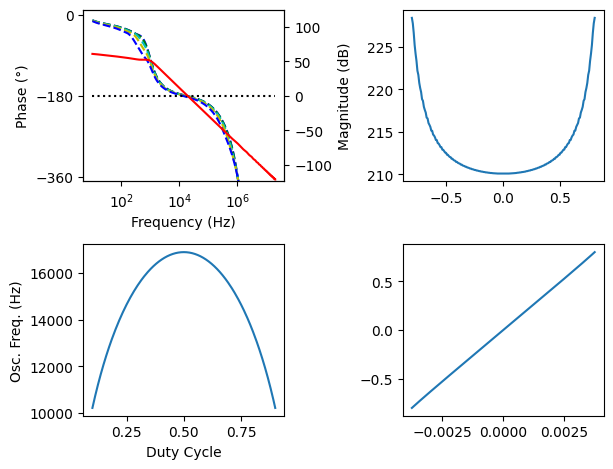

In [22]:
idx = -2
vals = X[idx,:-1][None,:]
delay = X[idx,-1]

problem.evaluate(X[idx][None,:])

num = problem._calc_num(vals)[0,::-1]
den = problem._calc_den(vals)[0,::-1]

plot(ct.tf(num, den), 10, 2e7, delay)

In [19]:
problem._vars

['C1', 'C2', 'C3', 'L1', 'R2', 'R3', 'R4', 'R5']

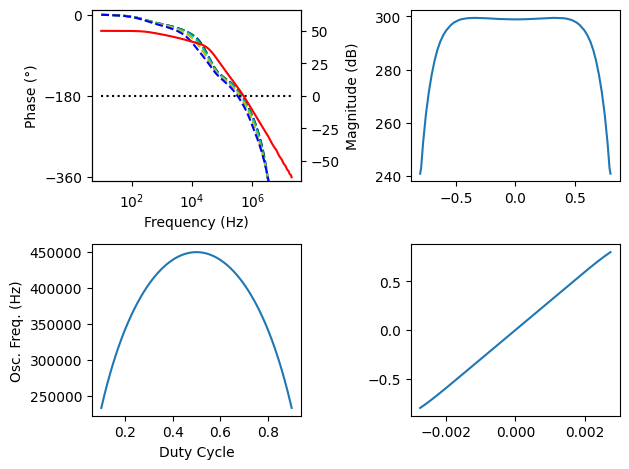

In [20]:
ref_tf = lpf(30e-6, 680e-9, 4) * fbn_example(1.8e3, 2.2e-9, 1e3, 330e-12, 8.2e3, 680)
plot(ref_tf, 10, 2e7, 160e-9)

['4.*R2', '4.*C3*R3*R4+4.*C3*R2*R5+4.*C3*R2*R4+4.*C3*R2*R3', '4.*C3*C2*R2*R3*R4']
['4.*R4+4.*R2', '4.*C2*R2*R4+4.*C3*R4*R5+4.*C3*R3*R4+4.*C3*R2*R5+4.*C3*R2*R4+4.*C3*R2*R3+4.*L1+L1*R4+L1*R2', '4.*C1*L1*R4+4.*C1*L1*R2+4.*C3*C2*R2*R4*R5+4.*C3*C2*R2*R3*R4+4.*C2*L1*R2+C2*L1*R2*R4+4.*C3*L1*R5+4.*C3*L1*R4+C3*L1*R4*R5+4.*C3*L1*R3+C3*L1*R3*R4+C3*L1*R2*R5+C3*L1*R2*R4+C3*L1*R2*R3', '4.*C2*C1*L1*R2*R4+4.*C3*C1*L1*R4*R5+4.*C3*C1*L1*R3*R4+4.*C3*C1*L1*R2*R5+4.*C3*C1*L1*R2*R4+4.*C3*C1*L1*R2*R3+4.*C3*C2*L1*R2*R5+4.*C3*C2*L1*R2*R4+C3*C2*L1*R2*R4*R5+4.*C3*C2*L1*R2*R3+C3*C2*L1*R2*R3*R4', '4.*C3*C2*C1*L1*R2*R4*R5+4.*C3*C2*C1*L1*R2*R3*R4']
[2.91468672e-08 3.08352000e-02 7.20000000e+03]
[1.46900211e-18 4.04118653e-12 2.17548036e-06 4.71667200e-01
 4.00000000e+04]
[1.91633249e-52 5.48392428e-46 4.13019284e-40 8.53863120e-35
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[9.65831576e-63 4.39807930e-56 6.22044398e-50 2.88895061e-44
 5.85516711e-39 4.74368400e-34 0.00000000e+00 0.00000000e+00
 0.0

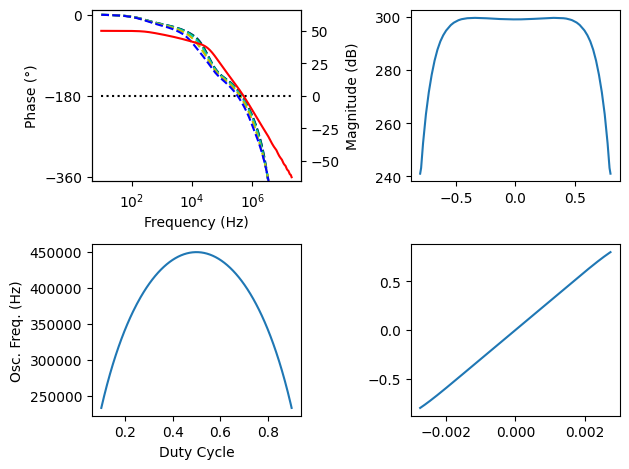

In [21]:
from modules.sapwin import Sapwin
problem = Sapwin(filename='../sym_analysis/SapWin/class_d_ucd.out')

vals = np.array([680e-9, 2.2e-9, 330e-12, 30e-6, 1.8e3, 680, 8.2e3, 1e3])[None,:]
delay = 160e-9

num = problem._calc_num(vals)[0,::-1]
den = problem._calc_den(vals)[0,::-1]

print(num)
print(den)

print(ref_tf.num[0][0])
print(ref_tf.den[0][0])

plot(ct.tf(num, den), 10, 2e7, delay)